# Answerability Classification

## Introduction
In the realm of Natural Language Processing (NLP), there are many fascinating challenges to tackle, one of which is question answering. The task is to build a model that can understand a given context and answer questions based on that context accurately.

The SQuAD 2.0 dataset, short for Stanford Question Answering Dataset, is a widely-recognized benchmark for this task. It contains pairs of paragraphs from Wikipedia and associated questions. Some of these questions are answerable given the context, while others are not.

In this study, we're taking a slightly different approach. Instead of focusing on generating the answers for these questions, we aim to classify whether a question is answerable or not based on the given context. This task is crucial as it can serve as a preliminary check before trying to answer a question, saving computational resources, and leading to more informed error handling in downstream applications.

To accomplish this, we'll leverage the power of Transformer models, specifically BERT (Bidirectional Encoder Representations from Transformers) based models. Transformers have revolutionized the field of NLP with their ability to understand the context of words in a sentence bidirectionally and handle long-term dependencies effectively.

Our choice of BERT is motivated by its robustness and generalizability, having been trained on a large corpus of text and shown outstanding performance on a wide range of NLP tasks. By fine-tuning this model, we can leverage the rich representations it has learned to effectively classify questions as answerable or unanswerable given a context.

In [13]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 9.8 MB/s eta 0:00:00


In [14]:
import random
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DefaultDataCollator
from transformers import TrainingArguments
from transformers import Trainer
from torch.utils.data import DataLoader
from transformers import default_data_collator
from accelerate import Accelerator
from transformers import BertForQuestionAnswering
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_scheduler

In [15]:
import os
from google.colab import drive

# Mount the Google drive storage
drive.mount('/content/drive')

# Move to the directory with the notebooks and the data set
# (note, you may need to change this path according to your directory structure)
os.chdir('/content/drive/MyDrive/NLP_project/dataset/')

# Check the currect working directory
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/NLP_project/dataset'

## Loading of the dataset SQuAD 2.0

In [ ]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

train_json = load_data('train-v2.0.json')
validation_json = load_data('dev-v2.0.json')

The structure of the training dataset is as follows:
- We have a list of main topics
- Each topic has a title and a list of paragraphs
- Each paragraph consists of a context and a list of questions and answers with the initial position of the first character of the answer in the context

The structure of the validation dataset is the same as that of the training dataset except that given a question we can have more plausible answers for that question, therefore we have a list of answers and start of positions for the first characters

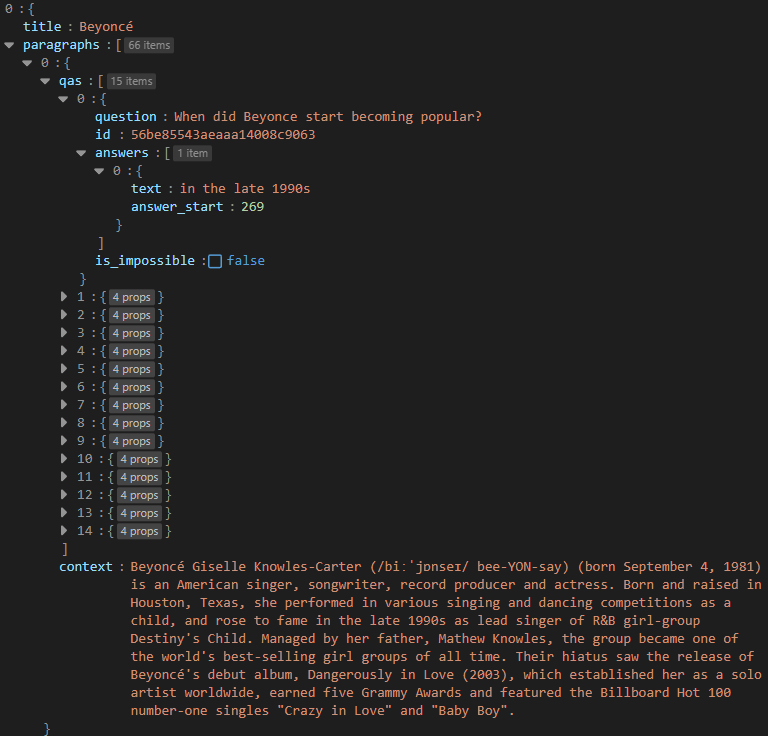


The `extract_data_from_json` function is where we open and extract data from json files of training and validation sets. The `is_possible` key, the label of answerability classification task, indicates whether a question is answerable or not.

In [ ]:
def extract_data_from_json(data):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [qas['answers'][0]['text']], 'answer_start': [int(qas['answers'][0]['answer_start'])]},
                                    'is_possible': True
                    })
                else:
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                   'question': qas['question'],
                                   'answers': {'text' : [''], 'answer_start': [0]},
                                    'is_possible': False
                    })

    return dataset

train_data = extract_data_from_json(train_json)
dev_data = extract_data_from_json(validation_json)

The following cell:
- Converts the data sets into the Huggingface data set API format
- Create a container with all the splits of the data set

In [ ]:
raw_datasets = DatasetDict()
raw_datasets['train'] = Dataset.from_list(train_data)
raw_datasets['validation'] = Dataset.from_list(dev_data)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answers', 'is_possible'],
        num_rows: 11873
    })
})

Since the task is binary classification we can easily see if the two classes are balanced.

In [ ]:
print("Training Set")
print("Total question: ", len(raw_datasets['train']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['train']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['train']["is_possible"])-sum(raw_datasets['train']["is_possible"]))

Training Set
Total question:  130319
Total answerable:  86821
Total unanswerable:  43498


For what concern the training set we can observe that our classes are clearely unbalanced with about twice as many answerable questions as unanswerable ones.

In [ ]:
print("Validation Set")
print("Total question: ", len(raw_datasets['validation']["is_possible"]))
print("Total answerable: ", sum(raw_datasets['validation']["is_possible"]))
print("Total unanswerable: ", len(raw_datasets['validation']["is_possible"])-sum(raw_datasets['validation']["is_possible"]))

Validation Set
Total question:  11873
Total answerable:  5928
Total unanswerable:  5945


For what concern the validation set the two classes are better balanced.

For a first trial we will train models with the data as given but then we will try to apply some class balancing techniques to see if we are able to improve our results.

## Hyper-Parameters

Here we define all the hyper-parameters that we need in order to properly preprocess our data and start a first training.

- max_length: the maximum length of the input beyond which the input is truncated
- stride: the stride needed to extract by moving a dynamic window of sub-contexts from an initial context with a length greater than the limit
- num_train_epochs: the number of epochs to train the model
- learning_rate: the learning rate used to train the model
- n_best: look at the logit scores for the highest start logits and end logits
- max_answer_length: we exclude answers that are too long by defining a maximum length
- model_name: the architecture of the model to train

In [ ]:
max_length = 384
stride = 128
num_train_epochs = 3
learning_rate = 2e-5
n_best = 20
max_answer_length = 50

We now load the tokenizer of the respective model used, which is used to preprocess the data to be provided to the model. For a first trail we will use *bert-base-cased*.

In [3]:
model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "bert-large-cased"
#model_name = "distilbert-base-cased"
#model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

## Preprocessing

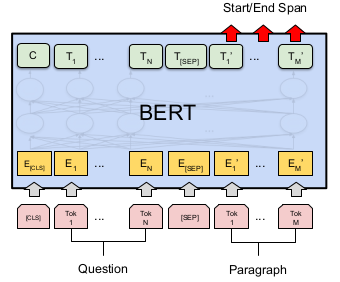

In order to train Bert on the *Question Answering Classification* task it is necessary to carry out an adequate preprocessing of the training data.
The structure required for the input is as follows:
- [CLS] Question tokens [SEP] Context tokens [SEP]

[CLS] specifies that we are performing a classification task

[SEP] specifies a separator used to separate question from context

It is possible to generate this input embedding using Bert's tokenizer and supplying the context and question string as input. 

As you can see, Bert uses sub-word tokenization.

In [4]:
inputs = tokenizer(
        "What causes precipitation to fall?", #Question
        "In meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity", #Context
        max_length=40,
        return_offsets_mapping=True,
        padding="max_length"
)
print("Embedding of the input composed by the question and the context")
print(inputs["input_ids"])
print("Length of embedding: ", len(inputs["input_ids"]))
print("Given the embedding of the input, we can retrieve the initial text with the special tokens")
print(tokenizer.decode(inputs["input_ids"]))
print("0 is the index for the padding token:", tokenizer.decode(0))
print("101 is the index for the classification token:", tokenizer.decode(101))
print("102 is the index for the classification token:", tokenizer.decode(102))
print("1899 is the index for the sub-word 'met' of meteorology:", tokenizer.decode(1899))
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("Sub-words tokenization:  ", [vocab_terms[vocab_index.index(i)] for i in inputs["input_ids"]])

Embedding of the input composed by the question and the context
[101, 1327, 4680, 14886, 1106, 2303, 136, 102, 1130, 1899, 25690, 4807, 117, 14886, 1110, 1251, 3317, 1104, 1103, 14255, 2883, 20414, 1104, 15129, 1447, 23548, 1204, 1115, 4887, 1223, 9926, 102, 0, 0, 0, 0, 0, 0, 0, 0]
Length of embedding:  40
Given the embedding of the input, we can retrieve the initial text with the special tokens
[CLS] What causes precipitation to fall? [SEP] In meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0 is the index for the padding token: [PAD]
101 is the index for the classification token: [CLS]
102 is the index for the classification token: [SEP]
1899 is the index for the sub-word 'met' of meteorology: met
Sub-words tokenization:   ['[CLS]', 'What', 'causes', 'precipitation', 'to', 'fall', '?', '[SEP]', 'In', 'met', '##eor', '##ology', ',', 'precipitation', 'is', 'any', 'pro

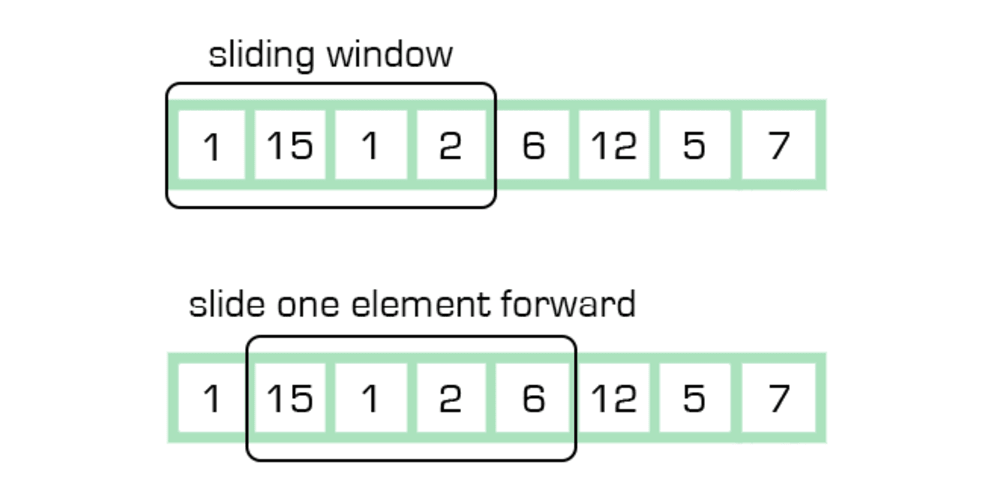

It is also possible to specify:
- max_length: the maximum length of the input beyond which the input is truncated
- truncation: if truncation is needed, you can specify whether to perform it on the question or context.
- stride: If the context and question exceeded the maximum length, it is possible to extract different sub-contexts by applying a stride with a dynamic window
- padding: If the context and the question have a length less than the maximum length, some padding is added

For example below, setting a maximum length of 25 and a stride of 10 we get 2 sub-contexts starting from the initial integer context because it exceeds the maximum length. With the truncation parameter we have specified that the truncation and the sliding window must be applied only on the context while the question is always entirely present.

In [10]:
inputs = tokenizer(
        "What causes precipitation to fall?", #Question
        "In meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity", #Context
        max_length=25,
        return_overflowing_tokens=True, # return all sub-contexts
        return_offsets_mapping=True,
        truncation="only_second",
        stride=10,
        padding="max_length"
)
print("Number of tuples of sub-context and question: ", len(inputs["input_ids"]))
print("First tuple of sub-context and question: ")
print(tokenizer.decode(inputs["input_ids"][0]))
print("Second tuple of sub-context and question: ")
print(tokenizer.decode(inputs["input_ids"][1]))
print("Third tuple of sub-context and question: ")
print(tokenizer.decode(inputs["input_ids"][2]))

Number of tuples of sub-context and question:  3
First tuple of sub-context and question: 
[CLS] What causes precipitation to fall? [SEP] In meteorology, precipitation is any product of the condensation of atmospheric [SEP]
Second tuple of sub-context and question: 
[CLS] What causes precipitation to fall? [SEP] is any product of the condensation of atmospheric water vaport that falls under [SEP]
Third tuple of sub-context and question: 
[CLS] What causes precipitation to fall? [SEP]densation of atmospheric water vaport that falls under gravity [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]


The output also needs to be preprocessed. In particular, it is necessary to determine the labels for the initial and final position of the initial and final sub-words that make up the response in the context, in particular in the subcontexts. So:
- If the answer is not inside the context or fully inside the context, the label is `False` and we consider the question as unanswerable
- If and only if the answer is totally contained in the context (or the subcontext) the label is `True` and we consider the question as answerable

As we saw in the previous example, the "gravity" response is present only in the third sub-context, consequently the expected labels would be `False`, `False`, `True`.

Therefore the code below allows for each tuple of sub-context and question to understand if the answer is entirely present in the sub-context or not and to compute the correct labels of the answer in the corresponding sub-context

In [12]:
offset_mapping = inputs.pop("offset_mapping")
sample_map = inputs.pop("overflow_to_sample_mapping")
answer = {'text': ["gravity"], 'answer_start': [110]}
labels = []

for i, offset in enumerate(offset_mapping):
  start_char = answer["answer_start"][0]
  end_char = answer["answer_start"][0] + len(answer["text"][0])
  sequence_ids = inputs.sequence_ids(i)

  # Find the start and end of the context
  idx = 0
  while sequence_ids[idx] != 1:
    idx += 1
    context_start = idx
  while sequence_ids[idx] == 1:
    idx += 1
    context_end = idx - 1

  # If the answer is not fully inside the context, label is False
  if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
    labels.append(False)
  else:
    labels.append(True)

print("Labels:", labels)

Labels: [False, False, True]


Now we can proceed by applying this preprocessing technique to both training and validation sets.

In [ ]:
def preprocess(data):
    questions = [q.strip() for q in data["question"]]
    inputs = tokenizer(
        questions,
        data["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = data["answers"]
    is_possible = data["is_possible"]
    labels = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if is_possible[sample_idx] == False:
          labels.append(0)
        else:
          # If the answer is not fully inside the context, label is (0, 0)
          if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            labels.append(0)
          else:
            labels.append(1)

    inputs["labels"] = labels
    return inputs

In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

(130319, 132079)

In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

(11873, 12199)

## First Training

### Bert Base Cased

We create the model first, using the AutoModelForSequenceClassification class.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

We define TrainingArguments which allows us to set some parameters for training such as:
- model_name: the name under which the model will be saved
- save_strategy: how often to save a checkpoint of the model, in our case at every epoch
- learning_rate: learning rate used for training
- num_train_epochs: number of epochs for training
- weight_decay: parameter to avoid overfitting
- fp16: it allows for reducing memory usage and accelerating training by utilizing faster computational operations

In [ ]:
args = TrainingArguments(
    model_name,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    fp16=True,
    metric_for_best_model="f1"
)

We just pass everything to the Trainer class using the Huggingface trainer API and launch the training. 

This is an example with the training of bert-base-cased with 3 epochs, 2e-5 learning rate and weight_decay 0.01

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.627100
1000,0.562000
1500,0.525500
2000,0.505400
2500,0.472000
3000,0.466700
3500,0.465400
4000,0.451400
4500,0.430400
5000,0.437000


TrainOutput(global_step=49530, training_loss=0.3033943002858885, metrics={'train_runtime': 11620.2878, 'train_samples_per_second': 34.099, 'train_steps_per_second': 4.262, 'total_flos': 7.819075143201024e+16, 'train_loss': 0.3033943002858885, 'epoch': 3.0})

#### Evaluation

In order to evaluate the performance of our models we use the following metrics:
*   $Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$
*   $Precision = \frac{TP}{TP+FP}$
*   $Recall = \frac{TP}{TP+FN}$
*   $F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

where 
*   `TP` (true prositives) is the number of correctly predicted answerable questions.
*   `TN` (true negatives) is the number of correctly predicted unanswerable questions.
*   `FP` (false prositives) is the number of wrongly predicted answerable questions.
*   `FN` (false negatives) is the number of wrongly predicted unanswerable questions.



In [ ]:
predictions, labels, _ = trainer.predict(validation_dataset)

In [ ]:
print("Total question: ", len(labels))
print("Total answerable: ", sum(labels))
print("Total unanswerable: ", len(labels)-sum(labels))

Total question:  12199
Total answerable:  5959
Total unanswerable:  6240


In order to make everything more understandable here there is a plot of the confusion matrix, which contains `TP`, `TN`, `FP` and `FN`.

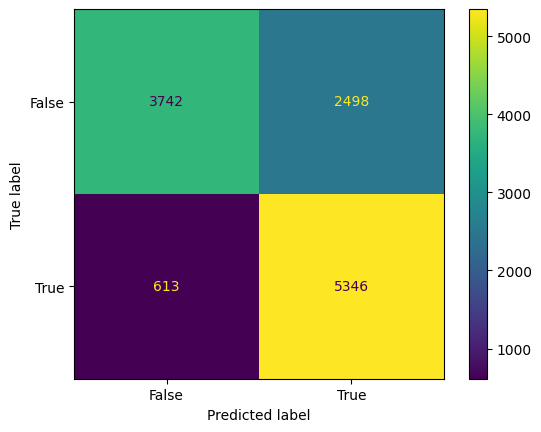

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(labels, np.argmax(predictions, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In the end here we have a print of all the previously described metrics.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(labels, np.argmax(predictions, axis=1))
recall = recall_score(labels, np.argmax(predictions, axis=1))
accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
f1 = f1_score(labels, np.argmax(predictions, axis=1))

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Precision: 0.6815400305966344
Recall: 0.8971303910052022
Accuracy: 0.7449790966472661
F1-score: 0.7746142143012389


In [ ]:
trainer.save_model("/content/drive/MyDrive/NLP_project/answerability_bert_base_cased_unbalanced")

## Class Balancing

As previously anticipated, since the two classes of our data are unbalanced we decided to apply some balancing technique to try to achieve better results. In particular we will apply downsampling and upsampling.

### Upsampling

The `upsampling` class balancing method consists in randomly pick a certain number of samples from the minority class and duplicate them in order to reach the same number of elements of the majority class.

We can see here that our data is unbalanced.

In [ ]:
print("Training Set")
print("Total question: ", len(train_dataset["labels"]))
print("Total answerable: ", sum(train_dataset["labels"]))
print("Total unanswerable: ", len(train_dataset["labels"])-sum(train_dataset["labels"]))

Training Set
Total question:  132079
Total answerable:  87043
Total unanswerable:  45036


In [ ]:
print("Validation Set")
print("Total question: ", len(validation_dataset["labels"]))
print("Total answerable: ", sum(validation_dataset["labels"]))
print("Total unanswerable: ", len(validation_dataset["labels"])-sum(validation_dataset["labels"]))

Validation Set
Total question:  12199
Total answerable:  5959
Total unanswerable:  6240


In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 132079
})

The first step consist in filtering from our original dataset dict two different pandas data frames, each one containing only samples belonging to one of the two classes.

In [ ]:
answerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/132079 [00:00<?, ? examples/s]

Filter:   0%|          | 0/132079 [00:00<?, ? examples/s]

At this point is possible to exploit the sample function in order to upsample unanswerable questions in order to reach the same cardinality of answerable ones.

In [ ]:
unanswerable_training = unanswerable_training.sample(n=len(answerable_training), random_state=42, replace=True)

We now concatenate the two dataframes and shuffle the samples.

In [ ]:
balanced_training = pd.concat([answerable_training, unanswerable_training])

balanced_training = balanced_training.sample(frac=1, random_state=42)

In the end the dataframe is reconverted into a huggingface dataset dict.

In [ ]:
upsampled_training = Dataset.from_pandas(balanced_training)

We can observe that now the two classes are perfectly balanced.

In [ ]:
print("Balanced Training Set")
print("Total question: ", len(upsampled_training["labels"]))
print("Total answerable: ", sum(upsampled_training["labels"]))
print("Total unanswerable: ", len(upsampled_training["labels"])-sum(upsampled_training["labels"]))

Balanced Training Set
Total question:  174086
Total answerable:  87043
Total unanswerable:  87043


At this point we repeat the same operation also for the validation set. 

In [ ]:
answerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/12199 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12199 [00:00<?, ? examples/s]

In [ ]:
answerable_validation = answerable_validation.sample(n=len(unanswerable_validation), random_state=42, replace=True)

In [ ]:
balanced_validation = pd.concat([answerable_validation, unanswerable_validation])

balanced_validation = balanced_validation.sample(frac=1, random_state=42)

In [ ]:
upsampled_validation = Dataset.from_pandas(balanced_validation)

In [ ]:
print("Balanced Validation Set")
print("Total question: ", len(upsampled_validation["labels"]))
print("Total answerable: ", sum(upsampled_validation["labels"]))
print("Total unanswerable: ", len(upsampled_validation["labels"])-sum(upsampled_validation["labels"]))

Balanced Validation Set
Total question:  12480
Total answerable:  6240
Total unanswerable:  6240


#### Bert Base Cased

`bert-base-cased` is now trained in the same way as before in order to make a comparison and see if we are able to obtain better results.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
args = TrainingArguments(
    model_name,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    fp16=True,
    metric_for_best_model="f1"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=upsampled_training,
    eval_dataset=upsampled_validation,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.644400
1000,0.574700
1500,0.521000
2000,0.513100
2500,0.493900
3000,0.469200
3500,0.453700
4000,0.445800
4500,0.443100
5000,0.417800


TrainOutput(global_step=65283, training_loss=0.246113160500045, metrics={'train_runtime': 15674.6995, 'train_samples_per_second': 33.319, 'train_steps_per_second': 4.165, 'total_flos': 1.0305889016265216e+17, 'train_loss': 0.246113160500045, 'epoch': 3.0})

##### Evaluation

Also the evaluation is performed in the same way.

In [18]:
print("Architure: ")
print(model)

Architure: 
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,)

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)

Total number of parameters: 108311810


In [ ]:
predictions, labels, _ = trainer.predict(validation_dataset)

In [ ]:
print("Total question: ", len(labels))
print("Total answerable: ", sum(labels))
print("Total unanswerable: ", len(labels)-sum(labels))

Total question:  12199
Total answerable:  5959
Total unanswerable:  6240


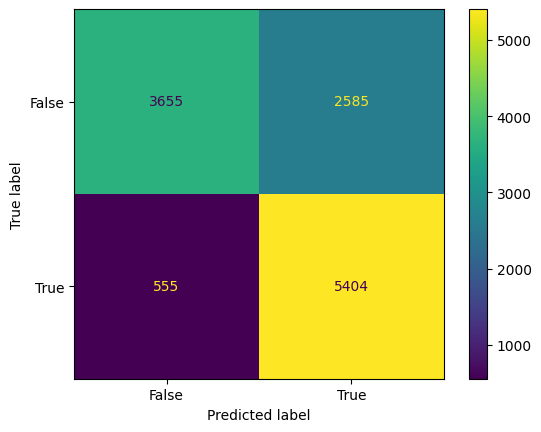

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(labels, np.argmax(predictions, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

We can compare the confusion matrixes and observe that the obtained results are slightly better with respect to the ones obtained with unbalanced classes.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(labels, np.argmax(predictions, axis=1))
recall = recall_score(labels, np.argmax(predictions, axis=1))
accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
f1 = f1_score(labels, np.argmax(predictions, axis=1))

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Precision: 0.6764300913756415
Recall: 0.9068635677127035
Accuracy: 0.7426018526108698
F1-score: 0.7748781187266991


In [ ]:
trainer.save_model("/content/drive/MyDrive/NLP_project/answerability_bert_base_cased_upsampled")

### Downsampling

The `downsampling` class balancing method consists in randomly delete a certain number of samples from the majority class in order to match the same number of elements of the minority class.

We can see here that our data is unbalanced.

In [ ]:
print("Training Set")
print("Total question: ", len(train_dataset["labels"]))
print("Total answerable: ", sum(train_dataset["labels"]))
print("Total unanswerable: ", len(train_dataset["labels"])-sum(train_dataset["labels"]))

Training Set
Total question:  132079
Total answerable:  87043
Total unanswerable:  45036


In [ ]:
print("Validation Set")
print("Total question: ", len(validation_dataset["labels"]))
print("Total answerable: ", sum(validation_dataset["labels"]))
print("Total unanswerable: ", len(validation_dataset["labels"])-sum(validation_dataset["labels"]))

Validation Set
Total question:  12199
Total answerable:  5959
Total unanswerable:  6240


In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 132079
})

The first step consist in filtering from our original dataset dict two different pandas data frames, each one containing only samples belonging to one of the two classes.

In [ ]:
answerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_training = pd.DataFrame(train_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/132079 [00:00<?, ? examples/s]

Filter:   0%|          | 0/132079 [00:00<?, ? examples/s]

At this point is possible to exploit the sample function in order to downsample answerable questions in order to reach the same cardinality of unanswerable ones.

In [ ]:
answerable_training = answerable_training.sample(n=len(unanswerable_training), random_state=42, replace=True)

We now concatenate the two dataframes and shuffle the samples.

In [ ]:
balanced_training = pd.concat([answerable_training, unanswerable_training])

balanced_training = balanced_training.sample(frac=1, random_state=42)

In the end the dataframe is reconverted into a huggingface dataset dict.

In [ ]:
downsampled_training = Dataset.from_pandas(balanced_training)

We can observe that now the two classes are perfectly balanced.

In [ ]:
print("Balanced Training Set")
print("Total question: ", len(downsampled_training["labels"]))
print("Total answerable: ", sum(downsampled_training["labels"]))
print("Total unanswerable: ", len(downsampled_training["labels"])-sum(downsampled_training["labels"]))

Balanced Training Set
Total question:  90072
Total answerable:  45036
Total unanswerable:  45036


At this point we repeat the same operation also for the validation set. 

In [ ]:
answerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 1))
unanswerable_validation = pd.DataFrame(validation_dataset.filter(lambda example: example['labels'] == 0))

Filter:   0%|          | 0/12199 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12199 [00:00<?, ? examples/s]

In [ ]:
unanswerable_validation = unanswerable_validation.sample(n=len(answerable_validation), random_state=42, replace=True)

In [ ]:
balanced_validation = pd.concat([answerable_validation, unanswerable_validation])

balanced_validation = balanced_validation.sample(frac=1, random_state=42)

In [ ]:
downsampled_validation = Dataset.from_pandas(balanced_validation)

In [ ]:
print("Balanced Validation Set")
print("Total question: ", len(downsampled_validation["labels"]))
print("Total answerable: ", sum(downsampled_validation["labels"]))
print("Total unanswerable: ", len(downsampled_validation["labels"])-sum(downsampled_validation["labels"]))

Balanced Validation Set
Total question:  11918
Total answerable:  5959
Total unanswerable:  5959


#### Bert Base Cased

`bert-base-cased` is now trained in the same way as before in order to make a comparison and see if we are able to obtain better results.

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
args = TrainingArguments(
    model_name,
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    fp16=True,
    metric_for_best_model="f1"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=downsampled_training,
    eval_dataset=downsampled_validation,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.664600
1000,0.569500
1500,0.526300
2000,0.514000
2500,0.482000
3000,0.470900
3500,0.470400
4000,0.431200
4500,0.432900
5000,0.435600


TrainOutput(global_step=33777, training_loss=0.2970679170458483, metrics={'train_runtime': 7970.6944, 'train_samples_per_second': 33.901, 'train_steps_per_second': 4.238, 'total_flos': 5.332261270136832e+16, 'train_loss': 0.2970679170458483, 'epoch': 3.0})

##### Evaluation

In [ ]:
predictions, labels, _ = trainer.predict(downsampled_validation)

In [ ]:
print("Total question: ", len(labels))
print("Total answerable: ", sum(labels))
print("Total unanswerable: ", len(labels)-sum(labels))

Total question:  11918
Total answerable:  5959
Total unanswerable:  5959


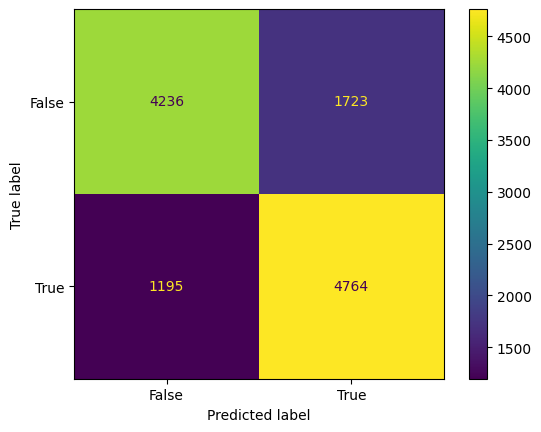

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

actual = np.random.binomial(1,.9,size = 1000)
predicted = np.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(labels, np.argmax(predictions, axis=1))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

We can compare the confusion matrixes and observe that the obtained results are worst with respect to the ones obtained with unbalanced classes or upsampled classes. Do we discard that method that probably leads to a large loss of information for our model.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(labels, np.argmax(predictions, axis=1))
recall = recall_score(labels, np.argmax(predictions, axis=1))
accuracy = accuracy_score(labels, np.argmax(predictions, axis=1))
f1 = f1_score(labels, np.argmax(predictions, axis=1))

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1-score:", f1)

Precision: 0.7343918606443657
Recall: 0.7994629971471724
Accuracy: 0.7551602617888907
F1-score: 0.7655471637473888


In [ ]:
trainer.save_model("/content/drive/MyDrive/NLP_project/answerability_bert_base_cased_downsampled")

## Final comparison between all trained models

The purpose of this last section of this notebook is to make a comparison between the results obtained from all the models that we have trained (notebooks for the training of every single model can be found in the folder). In particular we will compare the performances of:


*   `bert-base-cased`
*   `bert-base-uncased`
*   `roberta-base`
*   `bert-large-cased`
*   `distilbert-cased`

NOTE: alla the models have been trained using as input data the version of the dataset balanced with upsampling (that is the one that allowed to obtain the best results)



The main difference between cased and uncased lies in the treatment of uppercase and lowercase letters:
- In the "cased" version of BERT, the case of letters is preserved. Words are tokenized without altering the case of letters. For example, the words "Apple" and "apple" would be treated as two distinct tokens.
- In the "uncased" version of BERT, on the other hand, all letters are converted to lowercase during tokenization. So, both "Apple" and "apple" would be treated as the same token.

Bert-base-cased, Bert-base-uncased, Bert-large-cased and Ditilbert were trained with the following dataset:
-  BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers)

Instead Roberta was trained on a dataset composed of 5 datasets:
- BookCorpus, a dataset consisting of 11,038 unpublished books;
- English Wikipedia (excluding lists, tables and headers) ;
- CC-News, a dataset containing 63 millions English news articles crawled between September 2016 and February 2019.
- OpenWebText, an opensource recreation of the WebText dataset used to train GPT-2,
- Stories a dataset containing a subset of CommonCrawl data filtered to match the story-like style of Winograd schemas.

Furthermore all models were trained and evaluated with the following parameters:
- max_length = 384
- stride = 128
- num_train_epochs = 3 NOTE: The few epochs is due to the limitation of Colab which ensures training to a maximum of 8 hours (but actually crashed before 6 hours)
- learning_rate = 2e-5
- n_best = 20
- max_answer_length = 50


We can easily compare the performance of `accuracy`, `precision`, `recall` and `F1` metrics of the different models using a histogram.

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

bert-base-uncased  Accuracy:  0.74753  Precision:  0.68754  Recall:  0.90745  F1:  0.78234
bert-base-cased  Accuracy:  0.7426  Precision:  0.67643  Recall:  0.90686  F1:  0.77487
roberta-base  Accuracy:  0.81852  Precision:  0.75788  Recall:  0.9361  F1:  0.83761
bert-large-cased  Accuracy:  0.72339  Precision:  0.66392  Recall:  0.9048  F1:  0.76587
distilbert-cased  Accuracy:  0.65961  Precision:  0.61406  Recall:  0.85929  F1:  0.71627


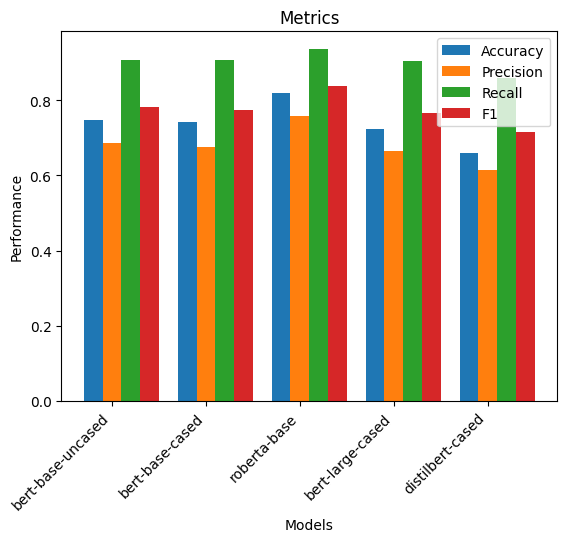

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['bert-base-uncased', 'bert-base-cased', 'roberta-base', 'bert-large-cased', 'distilbert-cased']
accuracy = [0.74753,0.74260,0.81852,0.72339,0.65961]
precision = [0.68754,0.67643,0.75788,0.66392,0.61406]
recall = [0.90745,0.90686,0.93610,0.90480,0.85929]
f1 = [0.78234,0.77487,0.83761,0.76587,0.71627]

for i in range(len(X)):
  print(X[i], " Accuracy: ", accuracy[i], " Precision: ", precision[i], " Recall: ", recall[i], " F1: ", f1[i])
  
X_axis = np.arange(len(X))
  
bar_width = 0.2 

plt.bar(X_axis - bar_width, accuracy, bar_width, label='Accuracy')
plt.bar(X_axis, precision, bar_width, label='Precision')
plt.bar(X_axis + bar_width, recall, bar_width, label='Recall')
plt.bar(X_axis + 2 * bar_width, f1, bar_width, label='F1')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("Metrics")
plt.legend()
plt.show()

We can observe that the best results are achieved by *roberta-base*, probably because this model is pre-trained on a larger corpus and for more time with respect to the standard versions of bert.

Particularly not great has been the performances of *bert-large*, probably because it is a huge model with a very big number of parameters that require more training time with respect to the three epochs we trained it because of the limited resources at our disposal.



We can also make a small comparison regarding the time spent training the models for three epochs. It can be seen that as the complexity of the models and therefore the number of parameters increases, the training time exponentially increases.

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

bert-base-uncased  Training time:  257  min
bert-base-cased  Training time:  261  min
roberta-base  Training time:  174  min
bert-large-cased  Training time:  747  min
distilbert-cased  Training time:  44  min


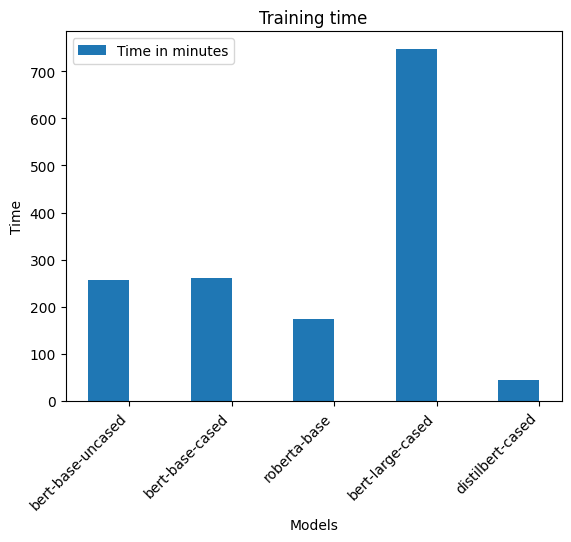

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['bert-base-uncased', 'bert-base-cased', 'roberta-base', 'bert-large-cased', 'distilbert-cased']
time = [257,261,174,747,44]
  
for i in range(len(X)):
  print(X[i], " Training time: ", time[i], " min")

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, time, 0.4, label = 'Time in minutes')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Training time")
plt.legend()
plt.show()

And finally we can compare the number of parameters for each model

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

bert-base-uncased  #Parameters:  109483778
bert-base-cased  #Parameters:  108311810
roberta-base  #Parameters:  124647170
bert-large-cased  #Parameters:  333581314
distilbert-cased  #Parameters:  65783042


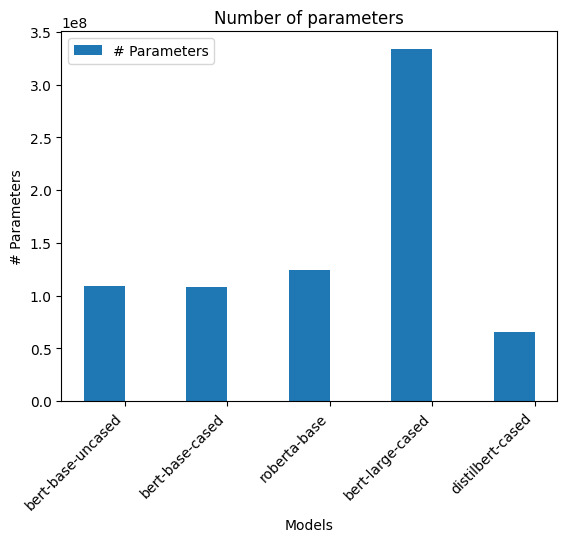

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['bert-base-uncased', 'bert-base-cased', 'roberta-base', 'bert-large-cased', 'distilbert-cased']
num_params = [109483778,108311810,124647170,333581314,65783042]
  
for i in range(len(X)):
  print(X[i], " #Parameters: ", num_params[i])

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, num_params, 0.4, label = '# Parameters')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("# Parameters")
plt.title("Number of parameters")
plt.legend()
plt.show()